# *The Data-Driven Guide to Living in London*

#### Install Folium, Requests and BeautifulSoup4

In [1]:
!conda install -c conda-forge folium --yes

!conda install -c conda-forge requests --yes

!conda install -c conda-forge beautifulsoup4 --yes

print('The installation was successful!')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

The installation was successful!


#### Import necessary libraries

In [3]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json
import requests

import folium
from folium.plugins import MarkerCluster

from IPython.display import Image 
from IPython.core.display import HTML

from pandas import DataFrame
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim
from bs4 import BeautifulSoup

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

print('Imported libraries!')

Imported libraries!


### Import average rent in London, by borough (1-bedroom apartment), create a dataframe and clean up a dataframe

In [4]:
# Import average rent in London, by borough
url = 'https://raw.githubusercontent.com/wrwnthn/Data-Driven-Guide-to-Living-in-London/master/'
london_avg_rent = f'{url}/london_average_rent_borough.csv'

print('Imported data!')

Imported data!


In [5]:
# Create dataframe
london_avg_rent_df= pd.read_csv(london_avg_rent)

# Preview dataframe
london_avg_rent_df.head()

,Year,Code,Borough,Category,Count of rents,Average,Lower quartile,Median,Upper quartile
0,2019,E09000001,City of London,One Bedroom,40,2083,1733,1950,2383
1,2019,E09000002,Barking and Dagenham,One Bedroom,210,965,875,950,1050
2,2019,E09000003,Barnet,One Bedroom,620,1147,1049,1150,1250
3,2019,E09000004,Bexley,One Bedroom,150,821,750,825,900
4,2019,E09000005,Brent,One Bedroom,400,1241,1100,1250,1352


In [6]:
# Delete columns
london_avg_rent_df.drop(['Year','Code','Category','Count of rents','Lower quartile','Median','Upper quartile'], axis=1, inplace=True)

# Rename column
london_avg_rent_df.rename(columns = {'Average': 'AverageRent'}, inplace=True)

# Preview table
london_avg_rent_df.head()

,Borough,AverageRent
0,City of London,2083
1,Barking and Dagenham,965
2,Barnet,1147
3,Bexley,821
4,Brent,1241


### Import a list of London boroughs with coordinates and create a dataframe from the list

In [7]:
# Import a list of London boroughs with coordinates
url = 'https://raw.githubusercontent.com/wrwnthn/Data-Driven-Guide-to-Living-in-London/master/'
london_borough_coord = f'{url}/london_borough_coordinates.csv'

print('Imported data!')

Imported data!


In [8]:
# Create a dataframe from the list
london_borough_coord_df = pd.read_csv(london_borough_coord)

# Preview dataframe
london_borough_coord_df.head()

,Code,Borough,BoroughLatitude,BoroughLongitude
0,E09000001,City of London,51.514994,-0.097278
1,E09000002,Barking and Dagenham,51.538697,0.080615
2,E09000003,Barnet,51.613135,-0.176590
3,E09000004,Bexley,51.456601,0.144324
4,E09000005,Brent,51.557138,-0.286130


### Join dataframes *london_borough_coord_df* and *london_avg_rent_df* so the joined dataframe will contain Borough, BoroughLatitude, BoroughLongitude and AverageRent

In [9]:
# Join two dataframes
london_data_df = pd.concat([london_borough_coord_df.set_index('Borough'), london_avg_rent_df.set_index('Borough')], axis=1, join='inner')
london_data_df.reset_index(inplace=True)

london_data_df.drop(['Code'], axis=1, inplace=True)

In [10]:
print(london_data_df.shape)
london_data_df.head(10)

(33, 4)


,Borough,BoroughLatitude,BoroughLongitude,AverageRent
0,City of London,51.514994,-0.097278,2083
1,Barking and Dagenham,51.538697,0.080615,965
2,Barnet,51.613135,-0.176590,1147
3,Bexley,51.456601,0.144324,821
4,Brent,51.557138,-0.286130,1241
5,Bromley,51.404552,0.015085,972
6,Camden,51.553257,-0.169305,1659
7,Croydon,51.373785,-0.099989,931
8,Ealing,51.513201,-0.304332,1216
9,Enfield,51.652181,-0.081471,1083


### Use BeautifulSoup to scrape a list of London Underground stations (Public Domain Tube Stations & Public Domain DLR Stations List)
*The list will include station name and station coordinates. A dataframe will be created and cleaned up.*

In [11]:
# Scrape a list of London Underground stations
wiki_url = requests.get('https://wiki.openstreetmap.org/wiki/List_of_London_Underground_stations').text
soup = BeautifulSoup(wiki_url, 'lxml')

In [12]:
# There are 2 wiki tables: Public Domain Tube Stations List & Public Domain DLR Stations List
wiki_tables = soup.find_all('table',{'class':'wikitable'})

In [13]:
# Create an empty list for scraped data
london_tube_station_list = []

# Start extracting data from the webpage
for table in wiki_tables:
    rows = table.find_all('tr')
    
    for row in rows:
        row_td = row.find_all('td')
        td_cell = str(row_td)
        td_text = BeautifulSoup(td_cell, 'lxml').get_text()
        clean_text_td = td_text.replace('\n','')
        london_tube_station_list.append(clean_text_td)
        
print(clean_text_td)
#print(london_tube_station_list)

[West Silvertown, 51.50335, +0.02208, Entrance (bus stop), User:Mattwestcott, 04/11/2006]


### Create a dataframe from London tube station list and clean up the dataframe

In [14]:
# Create dataframe of London tube station list
presplit_tube_station_df = pd.DataFrame(london_tube_station_list)

# Preview dataframe
presplit_tube_station_df.head()

,0
0,[]
1,"[Acton Town, 51.502500, -0.278126, Platform, U..."
2,"[Acton Central, 51.50883531, -0.263033174, Ent..."
3,"[Acton Central, 51.50856013, -0.262879534, Pla..."
4,"[Aldgate, 51.51394, -0.07537, Aldgate High Str..."


In [15]:
# Cleaning data by split text with ','
tube_station_df = presplit_tube_station_df[0].str.split(',', expand=True)

# Preview dataframe
print(tube_station_df.shape)
tube_station_df.head()

(344, 13)


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,[],None,None,None,None,None,None,None,None,None,None,None,None
1,[Acton Town,51.502500,-0.278126,Platform,User:Gagravarr,24/11/06,District,Piccadilly],None,None,None,None,None
2,[Acton Central,51.50883531,-0.263033174,Entrance,User:Firefishy,08/05/2007,London Overground],None,None,None,None,None,None
3,[Acton Central,51.50856013,-0.262879534,Platform,User:Firefishy,08/05/2007,London Overground],None,None,None,None,None,None
4,[Aldgate,51.51394,-0.07537,Aldgate High Street entrance,User:Morwen,28/4/2007,Metropolitan,No],None,None,None,None,None


In [16]:
# Remove '[' from column 0
tube_station_df[0] = tube_station_df[0].str.strip('[')

# Remove '+' from column 2 (longitude)
tube_station_df[2] = tube_station_df[2].str.replace('+', '')

# Remove row 0 and row 303 which are empty table header
tube_station_df.drop([0, 303], axis=0, inplace=True)

# Preview dataframe
print(tube_station_df.shape)
tube_station_df.head()

(342, 13)


,0,1,2,3,4,5,6,7,8,9,10,11,12
1,Acton Town,51.502500,-0.278126,Platform,User:Gagravarr,24/11/06,District,Piccadilly],None,None,None,None,None
2,Acton Central,51.50883531,-0.263033174,Entrance,User:Firefishy,08/05/2007,London Overground],None,None,None,None,None,None
3,Acton Central,51.50856013,-0.262879534,Platform,User:Firefishy,08/05/2007,London Overground],None,None,None,None,None,None
4,Aldgate,51.51394,-0.07537,Aldgate High Street entrance,User:Morwen,28/4/2007,Metropolitan,No],None,None,None,None,None
5,Aldgate East,51.51514,-0.07178,Entrance,User:Parsingphase,(2006),District,Hammersmith & City],None,None,None,None,None


In [17]:
# Remove column 3 - 12
tube_station_df.drop([3, 4, 5, 6, 7, 8, 9, 10, 11, 12], axis=1, inplace=True)

# Rename columns
tube_station_df.rename(columns = {0: 'Station', 1: 'StationLatitude', 2: 'StationLongitude'}, inplace=True)

# Preview dataframe
tube_station_df.head()

,Station,StationLatitude,StationLongitude
1,Acton Town,51.502500,-0.278126
2,Acton Central,51.50883531,-0.263033174
3,Acton Central,51.50856013,-0.262879534
4,Aldgate,51.51394,-0.07537
5,Aldgate East,51.51514,-0.07178


In [18]:
# Update lat/lng for row 43 Canada Water
tube_station_df.at[43, 'StationLatitude'] = 51.497991
tube_station_df.at[43, 'StationLongitude'] = -0.049703

# Update lat/lng for row 305 Bank
tube_station_df.at[305, 'StationLatitude'] = 51.513387
tube_station_df.at[305, 'StationLongitude'] = -0.088912

check_data = tube_station_df.loc[ [43 , 305] , : ]
print(check_data)

          Station StationLatitude StationLongitude
43   Canada Water          51.498        -0.049703
305          Bank         51.5134        -0.088912


In [19]:
# Remove tube stations located outside London: Grange Hill, Chigwell, Roding Valley, Buckhurst Hill, Loughton, Debden, Theydon Bois, Epping, Moor Park, Croxley, Watford, Rickmansworth, Chorleywood, Chalfont & Latimer, Amersham, and Chesham
tube_station_df.drop([7, 37, 48, 52, 53, 55, 64, 68, 84, 101, 159, 168, 213, 214, 253, 277], axis=0, inplace=True)

In [20]:
# Preview cleaned dataframe
print(tube_station_df.shape)
tube_station_df.head()

(326, 3)


,Station,StationLatitude,StationLongitude
1,Acton Town,51.502500,-0.278126
2,Acton Central,51.50883531,-0.263033174
3,Acton Central,51.50856013,-0.262879534
4,Aldgate,51.51394,-0.07537
5,Aldgate East,51.51514,-0.07178


### Create a choropleth map to show average rent in London, by borough and add a layer of density of London tube stations to the map

In [21]:
# Import geojson file of London borough polygons
london_geo = f'{url}/london_boroughs_boroughs_kml.geojson'

print('Imported data!')

Imported data!


In [22]:
# Use geocoder to obtain latitude and longitude of London
address = 'London, UK'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
london_lat = location.latitude
london_lng = location.longitude
print('The latitude of London, UK is {} and the longitude is {}.'.format(london_lat, london_lng))

The latitude of London, UK is 51.5073219 and the longitude is -0.1276474.


In [23]:
from folium.plugins import MarkerCluster

# Create a map of London
london_data_map = folium.Map(location=[london_lat,london_lng], zoom_start=11)

# Create a layer of choropleth
folium.Choropleth(
    geo_data = london_geo,
    name = 'London Average Rent Choropleth Map',
    data = london_data_df,
    columns = ['Borough', 'AverageRent'],
    key_on = 'feature.properties.name',
    fill_color = 'Greys', #PuRd
    fill_opacity = 0.7,
    line_opacity = 0,
    legend_name = 'London Average Rent by Borough (1-Bedroom)'
    ).add_to(london_data_map)

# Add MarkerCluster to the map
marker_cluster = MarkerCluster().add_to(london_data_map)

# Add tube station markers to the map
for station, station_lat, station_lng in zip(tube_station_df.Station, tube_station_df.StationLatitude, tube_station_df.StationLongitude):
    folium.CircleMarker(
        [station_lat, station_lng],
        radius = 3,
        popup = station,
        name = 'London Underground Stations',
        fill = True,
        color = 'blue',
        fill_color = 'blue',
        fill_opacity = 1
        ).add_to(marker_cluster)

# Display the map
london_data_map

### Using Foursquare API to obtain venues in each borough with given locations and create a dataframe of venues

In [24]:
CLIENT_ID = '5BWRJDZMYZZ2CXPLDBXTAF4KMQXZYQSF3X51RHCV3BTFJBPE' # Foursquare ID
CLIENT_SECRET = 'WKEKXX10PHPBSPA10FRMD0B5WE10KXFHRUYPUDNCZAJQOWJF' # Foursquare Secret
VERSION = '20191011'
print('Foursquare credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET: ' + CLIENT_SECRET)

Foursquare credentails:
CLIENT_ID: 5BWRJDZMYZZ2CXPLDBXTAF4KMQXZYQSF3X51RHCV3BTFJBPE
CLIENT_SECRET: WKEKXX10PHPBSPA10FRMD0B5WE10KXFHRUYPUDNCZAJQOWJF


In [25]:
# Set radius and limit of venues for each borough
radius = 1000 # 1km around the borough location
limit = 100

# Create empty list for venue data
venues = []

# Start extracting venue data via Foursquare API
for lat, lng, borough in zip(london_data_df['BoroughLatitude'], london_data_df['BoroughLongitude'], london_data_df['Borough']):
    fsq_url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        lng,
        radius, 
        limit)
    
    results = requests.get(fsq_url).json()["response"]['groups'][0]['items']
    
    for venue in results:
        venues.append((
            borough,
            lat, 
            lng, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [26]:
# Put the venues into a dataframe
venues_df = pd.DataFrame(venues)
venues_df.columns = ['Borough', 'BoroughLatitude', 'BoroughLongitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueType']

# Check the dataframe
print(venues_df.shape)
print('There are {} unique venue types.'.format(len(venues_df['VenueType'].unique())))
venues_df.head()

(2475, 7)
There are 250 unique venue types.


,Borough,BoroughLatitude,BoroughLongitude,VenueName,VenueLatitude,VenueLongitude,VenueType
0,City of London,51.514994,-0.097278,Pilpel,51.515195,-0.098462,Falafel Restaurant
1,City of London,51.514994,-0.097278,M&S Simply Food,51.513527,-0.096170,Grocery Store
2,City of London,51.514994,-0.097278,One New Change Rooftop,51.513912,-0.095775,Roof Deck
3,City of London,51.514994,-0.097278,Christ Church Greyfriars Garden,51.515670,-0.098760,Garden
4,City of London,51.514994,-0.097278,Postman's Park,51.516860,-0.097643,Park


### Plot bar graph of total number of venue in each borough

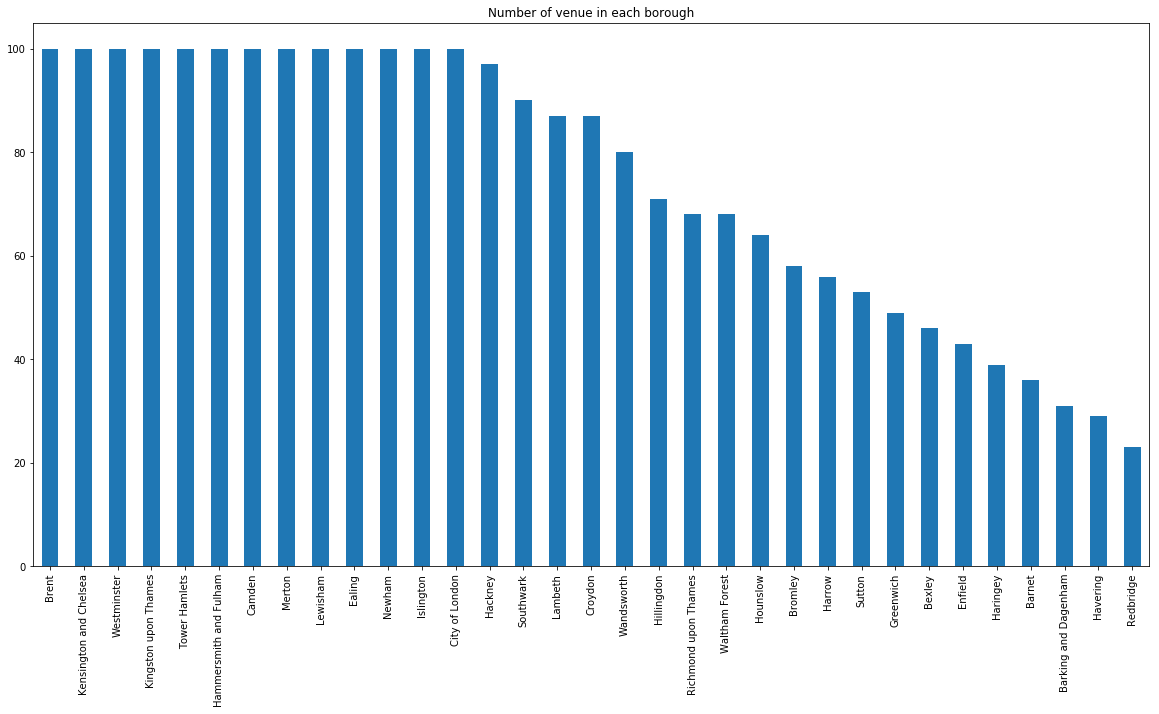

In [27]:
# Plot bar graph of the number of venue in each borough
venues_df['Borough'].value_counts().plot(kind='bar',figsize=(20,10))

plt.title('Number of venue in each borough')
plt.show()

In [28]:
# One-hot encoding
venues_type_onehot = pd.get_dummies(venues_df[['VenueType']], prefix="", prefix_sep="")

# Adding the borough column
venues_type_onehot['Borough'] = venues_df['Borough']

# Rearrange borough column to be the first column
cols = venues_type_onehot.columns.tolist()
cols = cols[-1:] + cols[:-1]
venues_type_onehot = venues_type_onehot[cols]

print(venues_type_onehot.shape)
venues_type_onehot.head()

(2475, 251)


,Borough,Accessories Store,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bistro,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buddhist Temple,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Canal,Canal Lock,Caribbean Restaurant,Casino,Chaat Place,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Community Center,Community College,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Hill,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Iraqi Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Lebanese Restaurant,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mobile Phone Shop,Modern European Restaurant,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Outlet Mall,Outlet Store,Pakistani Restaurant,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Restaurant,River,Road,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shaanxi Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Soccer Field,Soccer Stadium,Social Club,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Trail,Train Station,Tram Station,Turkish Restaurant,Udon Restaurant,Vape Store,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Windmill,Wine Bar,Wine Shop,Winery,Women's Store,Xinjiang Restaurant,Yoga Studio
0,City of London,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [29]:
# Group rows by borough and by taking the mean of the frequency of occurrence of each category
venue_count_df = venues_type_onehot.groupby(['Borough']).mean().reset_index()

# Preview data
print(venue_count_df.shape)
venue_count_df.head()

(33, 251)


,Borough,Accessories Store,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bistro,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buddhist Temple,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Canal,Canal Lock,Caribbean Restaurant,Casino,Chaat Place,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Community Center,Community College,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Hill,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Iraqi Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Lebanese Restaurant,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mobile Phone Shop,Modern European Restaurant,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Outlet Mall,Outlet Store,Pakistani Restaurant,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Restaurant,River,Road,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shaanxi Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Soccer Field,Soccer Stadium,Social Club,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Trail,Train Station,Tram Station,Turkish Restaurant,Udon Restaurant,Vape Store,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Windmill,Wine Bar,Wine Shop,Winery,Women's Store,Xinjiang Restaurant,Yoga Studio
0,Barking and Dagenham,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.00,0.000000,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.0,0.032258,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.032258,0.000000,0.0,0.000000,0.0,0.064516,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.032258,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.

In [30]:
# Print each borough along with the top 5 most common venues
num_top_venues = 5

for hood in venue_count_df['Borough']:
    print("----"+hood+"----")
    temp = venue_count_df[venue_count_df['Borough'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Barking and Dagenham----
           venue  freq
0  Grocery Store  0.13
1          Hotel  0.13
2    Supermarket  0.10
3           Park  0.06
4    Coffee Shop  0.06


----Barnet----
                  venue  freq
0           Coffee Shop  0.14
1         Grocery Store  0.08
2  Fast Food Restaurant  0.06
3  Gym / Fitness Center  0.06
4           Supermarket  0.06


----Bexley----
                  venue  freq
0                   Pub  0.15
1        Clothing Store  0.09
2  Fast Food Restaurant  0.07
3           Coffee Shop  0.07
4           Supermarket  0.07


----Brent----
            venue  freq
0     Coffee Shop  0.10
1           Hotel  0.07
2  Clothing Store  0.07
3   Grocery Store  0.05
4             Bar  0.05


----Bromley----
            venue  freq
0             Pub  0.14
1     Coffee Shop  0.09
2  Clothing Store  0.09
3     Supermarket  0.03
4     Pizza Place  0.03


----Camden----
                venue  freq
0                Café  0.10
1                 Pub  0.09
2              B

In [31]:
# Function for sorting venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Create a new dataframe to display the top 10 venues for each borough

In [32]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create a new dataframe
borough_venues_sorted = pd.DataFrame(columns=columns)
borough_venues_sorted['Borough'] = venue_count_df['Borough']

for ind in np.arange(venue_count_df.shape[0]):
    borough_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venue_count_df.iloc[ind, :], num_top_venues)

print(borough_venues_sorted.shape)
borough_venues_sorted.head()

(33, 11)


,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,Hotel,Grocery Store,Supermarket,Park,Coffee Shop,Gym,Portuguese Restaurant,Steakhouse,Spa,Business Service
1,Barnet,Coffee Shop,Grocery Store,Gym / Fitness Center,Fast Food Restaurant,Supermarket,Pub,Breakfast Spot,Tea Room,Gift Shop,Sushi Restaurant
2,Bexley,Pub,Clothing Store,Coffee Shop,Fast Food Restaurant,Supermarket,Grocery Store,Hotel,Italian Restaurant,Furniture / Home Store,Greek Restaurant
3,Brent,Coffee Shop,Hotel,Clothing Store,Bar,Grocery Store,Sporting Goods Shop,Sandwich Place,Fast Food Restaurant,Pizza Place,Indian Restaurant
4,Bromley,Pub,Clothing Store,Coffee Shop,Supermarket,Pizza Place,Burger Joint,Indian Restaurant,Gym / Fitness Center,Café,Bar


### Building classification model

In [33]:
# Set number of clusters
kclusters = 3

london_venue_clustering = venue_count_df.drop('Borough', 1)

# Run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_venue_clustering)

# Check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 1, 2, 2, 2, 1, 1, 1, 1, 2], dtype=int32)

### Create dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [34]:
# Add clustering labels
borough_venues_sorted.insert(0, 'ClusterLabels', kmeans.labels_)

london_merged = london_data_df

# Merge borough_venues_sorted with london_data_df to add latitude/longitude for each Borough
london_merged = london_merged.join(borough_venues_sorted.set_index('Borough'), on='Borough')

london_merged.head()

,Borough,BoroughLatitude,BoroughLongitude,AverageRent,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,City of London,51.514994,-0.097278,2083,1,Coffee Shop,Hotel,Gym / Fitness Center,Vietnamese Restaurant,Scenic Lookout,Italian Restaurant,Café,Falafel Restaurant,Wine Bar,English Restaurant
1,Barking and Dagenham,51.538697,0.080615,965,0,Hotel,Grocery Store,Supermarket,Park,Coffee Shop,Gym,Portuguese Restaurant,Steakhouse,Spa,Business Service
2,Barnet,51.613135,-0.176590,1147,1,Coffee Shop,Grocery Store,Gym / Fitness Center,Fast Food Restaurant,Supermarket,Pub,Breakfast Spot,Tea Room,Gift Shop,Sushi Restaurant
3,Bexley,51.456601,0.144324,821,2,Pub,Clothing Store,Coffee Shop,Fast Food Restaurant,Supermarket,Grocery Store,Hotel,Italian Restaurant,Furniture / Home Store,Greek Restaurant
4,Brent,51.557138,-0.286130,1241,2,Coffee Shop,Hotel,Clothing Store,Bar,Grocery Store,Sporting Goods Shop,Sandwich Place,Fast Food Restaurant,Pizza Place,Indian Restaurant


### Plot bar graph of number of venue in each cluster from the merged dataframe

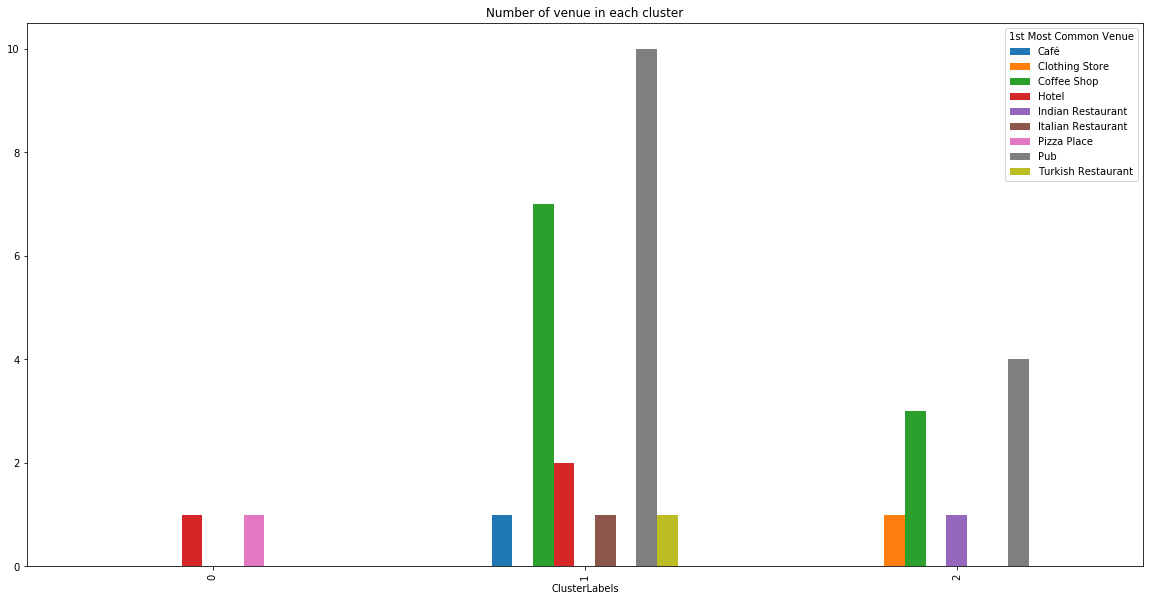

In [35]:
# Plot bar graph of number of venue in each cluster from the merged dataframe

london_merged.groupby(['ClusterLabels','1st Most Common Venue']).size().unstack().plot(kind='bar',stacked=False,figsize=(20,10))

plt.title('Number of venue in each cluster')
plt.show()

In [36]:
# Name these clusters

# cluster 0:
cluster_0 = 'Pizza and Hotel Venues'

# cluster 1:
cluster_1 = 'Intensive Pub & Coffee Shop Venues'

# cluster 2:
cluster_2 = 'Pub & Coffee Shop Venues'

In [37]:
# Add cluster name & cluster color for each borough

# Create an empty list
london_cluster_data = []

# Set color for each cluster label
for borough, cluster_label in zip(london_merged['Borough'], london_merged['ClusterLabels']):
    if cluster_label == 0:
        cluster_name = cluster_0
        cluster_color = 'red'
    elif cluster_label == 1:
        cluster_name = cluster_1
        cluster_color = 'green'
    elif cluster_label == 2:
        cluster_name = cluster_2
        cluster_color = 'orange'
    else:
        print('error')
    london_cluster_data.append((borough, cluster_label, cluster_name, cluster_color))

print(london_cluster_data)

[('City of London', 1, 'Intensive Pub & Coffee Shop Venues', 'green'), ('Barking and Dagenham', 0, 'Pizza and Hotel Venues', 'red'), ('Barnet', 1, 'Intensive Pub & Coffee Shop Venues', 'green'), ('Bexley', 2, 'Pub & Coffee Shop Venues', 'orange'), ('Brent', 2, 'Pub & Coffee Shop Venues', 'orange'), ('Bromley', 2, 'Pub & Coffee Shop Venues', 'orange'), ('Camden', 1, 'Intensive Pub & Coffee Shop Venues', 'green'), ('Croydon', 1, 'Intensive Pub & Coffee Shop Venues', 'green'), ('Ealing', 1, 'Intensive Pub & Coffee Shop Venues', 'green'), ('Enfield', 2, 'Pub & Coffee Shop Venues', 'orange'), ('Greenwich', 2, 'Pub & Coffee Shop Venues', 'orange'), ('Hackney', 1, 'Intensive Pub & Coffee Shop Venues', 'green'), ('Hammersmith and Fulham', 1, 'Intensive Pub & Coffee Shop Venues', 'green'), ('Haringey', 1, 'Intensive Pub & Coffee Shop Venues', 'green'), ('Harrow', 2, 'Pub & Coffee Shop Venues', 'orange'), ('Havering', 1, 'Intensive Pub & Coffee Shop Venues', 'green'), ('Hillingdon', 2, 'Pub & Co

In [38]:
# Create dataframe of london_cluster_data
london_cluster_df = pd.DataFrame(london_cluster_data)

# Remove ClusterLabels before merging dataframe
london_cluster_df.drop([1], axis=1, inplace=True)

# Rename columns
london_cluster_df.rename(columns = {0: 'Borough', 2: 'ClusterName', 3: 'ClusterColor'}, inplace=True)

print(london_cluster_df.shape)
london_cluster_df.head()

(33, 3)


,Borough,ClusterName,ClusterColor
0,City of London,Intensive Pub & Coffee Shop Venues,green
1,Barking and Dagenham,Pizza and Hotel Venues,red
2,Barnet,Intensive Pub & Coffee Shop Venues,green
3,Bexley,Pub & Coffee Shop Venues,orange
4,Brent,Pub & Coffee Shop Venues,orange


### Merge master dataframe with cluster dataframe 

In [39]:
# Merge master dataframe london_merged with cluster dataframe
london_merged = london_merged.join(london_cluster_df.set_index('Borough'), on='Borough')

In [40]:
# Sorted by cluster labels
london_merged.sort_values(['ClusterLabels'], inplace=True, ascending=False)

# Check cluster label for each row
london_merged.head()

,Borough,BoroughLatitude,BoroughLongitude,AverageRent,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,ClusterName,ClusterColor
16,Hillingdon,51.547584,-0.471286,1018,2,Coffee Shop,Clothing Store,Fast Food Restaurant,Pub,Italian Restaurant,Sandwich Place,Gym,Pharmacy,Supermarket,Gym / Fitness Center,Pub & Coffee Shop Venues,orange
28,Sutton,51.362049,-0.192527,920,2,Pub,Clothing Store,Coffee Shop,Café,Pizza Place,Grocery Store,Italian Restaurant,Women's Store,Supermarket,Bakery,Pub & Coffee Shop Venues,orange
17,Hounslow,51.468899,-0.366531,1153,2,Indian Restaurant,Grocery Store,Hotel,Coffee Shop,Clothing Store,Fast Food Restaurant,Bakery,Asian Restaurant,Supermarket,Sandwich Place,Pub & Coffee Shop Venues,orange
14,Harrow,51.580758,-0.333942,1093,2,Coffee Shop,Clothing Store,Pub,Indian Restaurant,Pizza Place,Bar,Gym / Fitness Center,Gym,Grocery Store,Sandwich Place,Pub & Coffee Shop Venues,orange
10,Greenwich,51.486899,0.023179,1155,2,Clothing Store,Pub,Coffee Shop,Supermarket,Discount Store,Shopping Plaza,Furniture / Home Store,Convenience Store,Grocery Store,Bus Stop,Pub & Coffee Shop Venues,orange


### Visualize the resulting clusters

In [41]:
# Add borough markers to the map
for lat, lon, borough, cluster, color, rent in zip(
    london_merged['BoroughLatitude'], 
    london_merged['BoroughLongitude'], 
    london_merged['Borough'], 
    london_merged['ClusterName'], 
    london_merged['ClusterColor'], 
    london_merged['AverageRent']):
    label = folium.Popup(str(borough) + ' | ' + str(cluster) + ' | Average Rent: £' + str(rent), parse_html=True, max_width=500,min_width=200)
    folium.CircleMarker(
        [lat, lon],
        radius = 6,
        popup = label,
        name = 'London Boroughs',
        color = color,
        fill = True,
        fill_color = color,
        fill_opacity = 1
        ).add_to(london_data_map)

# Add LayerControl to the map 
folium.LayerControl().add_to(london_data_map)    

london_data_map